<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connection to GDrive and download of all the datasets

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d davidedemarco/healthy-unhealthy-plants-dataset-segmented --unzip


100% 640M/642M [00:21<00:00, 46.6MB/s]
100% 642M/642M [00:21<00:00, 31.5MB/s]


In [ ]:
# downaload the noise images from https://drive.google.com/file/d/1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm/view?usp=sharing

! gdown --id 1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm -O noise.zip

Downloading...
From: https://drive.google.com/uc?id=1wsrC7u104hsAU6Wo0cII33TLC3oLpTkm
To: /content/noise.zip
100% 3.08G/3.08G [00:56<00:00, 54.5MB/s]


In [ ]:
! unzip /content/noise.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5499.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags55.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags550.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5500.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5501.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5502.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5503.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5504.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5505.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5506.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5507.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5508.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags5509.txt  
  inflating: mirflickr25k/mirflickr/meta/tags_raw/tags551.txt  
  inflating: mirflickr25k/mirflickr/meta/tag

## Imports

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm.auto import tqdm

from IPython.display import display
from ipywidgets import HBox, Image, HTML

import tensorflow as tf

import numpy as np

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Creation of DataFrames for noise images and leaves images

In [ ]:
directories = ["Apple", "Blueberry", "Cherry", "Corn", "Grape", "Orange", "Peach", "Pepper", "Potato", "Raspberry", "Soybean", "Squash", "Strawberry", "Tomato"]
leaves_dataframe = pd.DataFrame(columns=['Image', 'Plant', 'Path'])
for plant in tqdm(directories):
  leaf_path = '/content/Healthy-Unhealthy-Plants-Dataset-Segmented/' + plant
  image_paths = listdir(leaf_path)
  for path in tqdm(image_paths):
    leaves_dataframe = leaves_dataframe.append({'Image': path, 'Plant': plant, 'Path': leaf_path}, ignore_index=True)



  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/4159 [00:00<?, ?it/s]

  0%|          | 0/1969 [00:00<?, ?it/s]

  0%|          | 0/2489 [00:00<?, ?it/s]

  0%|          | 0/5058 [00:00<?, ?it/s]

  0%|          | 0/5521 [00:00<?, ?it/s]

  0%|          | 0/7255 [00:00<?, ?it/s]

  0%|          | 0/3634 [00:00<?, ?it/s]

  0%|          | 0/3240 [00:00<?, ?it/s]

  0%|          | 0/2868 [00:00<?, ?it/s]

  0%|          | 0/635 [00:00<?, ?it/s]

  0%|          | 0/6706 [00:00<?, ?it/s]

  0%|          | 0/2409 [00:00<?, ?it/s]

  0%|          | 0/2238 [00:00<?, ?it/s]

  0%|          | 0/23853 [00:00<?, ?it/s]

In [ ]:
leaves_dataframe



,Image,Plant,Path
0,6643566f-d980-4bdb-88d7-4d3ab3c771fa___FREC_Sc...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
1,753a02e9-3624-4692-a0c9-ccb78c8f916b___RS_HL 5...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
2,4c368acb-0a47-4c7f-84bd-29dc74660db9___RS_HL 5...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
3,99a971b6-cd13-4ed2-8fc5-0d6769945578___FREC_Sc...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
4,15f31b47-61da-4549-ad60-f13ef13a6512___JR_FrgE...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
...,...,...,...
72029,749e717c-f4d4-44ec-9265-1cb37aae66ca___UF.GRC_...,Tomato,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
72030,93e37751-6fc2-41fb-b0fd-9639cba54c98___UF.GRC_...,Tomato,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
72031,2a67b51d-1ad6-4ab9-8a1d-db599f8593f3___YLCV_NR...,Tomato,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
72032,7620a603-c3cd-4893-9481-901c9950bb00___GH_HL L...,Tomato,/content/Healthy-Unhealthy-Plants-Dataset-Segm...


In [ ]:
noise_path = "/content/mirflickr25k/mirflickr"
noise_images = [f for f in listdir(noise_path) if isfile(join(noise_path, f))]


In [ ]:
noise_dataframe = pd.DataFrame(columns=['Image', 'Plant', 'Path'])

for image_path in tqdm(noise_images):
  noise_dataframe = noise_dataframe.append({'Image': image_path, 'Plant': "noise", 'Path': noise_path}, ignore_index=True)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
noise_dataframe

,Image,Plant,Path
0,im23788.jpg,noise,/content/mirflickr25k/mirflickr
1,im321.jpg,noise,/content/mirflickr25k/mirflickr
2,im10948.jpg,noise,/content/mirflickr25k/mirflickr
3,im1177.jpg,noise,/content/mirflickr25k/mirflickr
4,im16324.jpg,noise,/content/mirflickr25k/mirflickr
...,...,...,...
24995,im8266.jpg,noise,/content/mirflickr25k/mirflickr
24996,im19378.jpg,noise,/content/mirflickr25k/mirflickr
24997,im14944.jpg,noise,/content/mirflickr25k/mirflickr
24998,im7647.jpg,noise,/content/mirflickr25k/mirflickr


In [ ]:
frames = [leaves_dataframe, noise_dataframe]

total_dataframe = pd.concat(frames)

total_dataframe

,Image,Plant,Path
0,00348.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
1,f415bc3e-3e71-4636-a3dd-78b65002384d___JR_FrgE...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
2,22717.jpg,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
3,4dc8e2a8-4374-488a-afc6-fd0ea7f15c88___FREC_C....,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
4,4b186022-c0ab-4a26-9930-c7944a3c431e___RS_HL 7...,Apple,/content/Healthy-Unhealthy-Plants-Dataset-Segm...
...,...,...,...
24995,im8266.jpg,noise,/content/mirflickr25k/mirflickr
24996,im19378.jpg,noise,/content/mirflickr25k/mirflickr
24997,im14944.jpg,noise,/content/mirflickr25k/mirflickr
24998,im7647.jpg,noise,/content/mirflickr25k/mirflickr


# General Functions

In [ ]:
def display_image(image_path, title='', txt=''):
  """ Displays an image with optional title and text next to it using iPython
  widgets (works in Jupyter/Colab environments).
      
  Args:
    image_path (string): path to the image to show.
    title (string): header text to show next to the image.
    txt (string): text to show under the title header.
  """
  image_widget = Image.from_file(image_path, width=200, height=100)
  txt = txt.replace('\n', '<br>')
  text_widget = HTML('<p><b>{}</b></p><p>{}</p>'.format(title, txt))
  widget = HBox([image_widget, text_widget])
  display(widget)

In [ ]:
def show_results(image_paths, scores, captions=None):
  """
  Shows results of a similarity search. Lists of image paths, scores, and
  (optionally) captions must be of the same length and follow the same order.

  Args:
    image_paths (ndarray or list): ordererd paths of images to be shown.
    scores (ndarray or list): ordered scores values to be shown next to images.
    captions (ndarray or list): ordered strings of captions to be shown; if
                                None, no caption is shown. Defaults to None.
  
  """
  if captions is None:
    captions = [''] * len(scores)  # just all empty strings

  for image_path, score, caption in zip(image_paths, scores, captions):
    title = 'score: {:.6f}'.format(score)
    display_image(image_path, title, caption)

# Feature Extraction and BruteForce tests

In [ ]:
model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                       

In [ ]:
noise_paths = noise_dataframe.Path + '/' + noise_dataframe.Image


noise_features = []

image_width = 224
image_height = 224
image_size = (image_height, image_width)

for path in tqdm(noise_paths):
  image_pil = tf.keras.utils.load_img(path, target_size=image_size, interpolation='bilinear')
  image_np = tf.keras.preprocessing.image.img_to_array(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = model(image_np).numpy()
  noise_features.append(image_feature_vector)

noise_features = np.concatenate(noise_features, axis=0)

np.savez("noise_features_final.npz", noise_features)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
image_paths = "/content/Healthy-Unhealthy-Plants-Dataset-Segmented/" + leaves_dataframe.Plant + '/' + leaves_dataframe.Image


features = []

image_width = 224
image_height = 224
image_size = (image_height, image_width)

for path in tqdm(image_paths):
  image_pil = tf.keras.utils.load_img(path, target_size=image_size, interpolation='bilinear')
  image_np = tf.keras.preprocessing.image.img_to_array(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = model(image_np).numpy()
  features.append(image_feature_vector)

features = np.concatenate(features, axis=0)
np.savez("features_final.npz", features)

  0%|          | 0/72034 [00:00<?, ?it/s]

Concatenate the two features vector and attach it to the dataframe

In [3]:
# feature https://drive.google.com/file/d/1MClSLlPJ4iAuYugiXuPa8z3MEDwR79SK/view?usp=sharing
# noise feature https://drive.google.com/file/d/1_T3vAVOgSMp9UxUhYuIp28AnDIngQO9d/view?usp=sharing
! gdown --id 1MClSLlPJ4iAuYugiXuPa8z3MEDwR79SK

a = np.load('features_final.npz')

features = a['arr_0']

!gdown --id 1_T3vAVOgSMp9UxUhYuIp28AnDIngQO9d

b = np.load('noise_features_final.npz')

noise_features = b['arr_0']


Downloading...
From: https://drive.google.com/uc?id=1MClSLlPJ4iAuYugiXuPa8z3MEDwR79SK
To: /content/features_final.npz
100% 295M/295M [00:02<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_T3vAVOgSMp9UxUhYuIp28AnDIngQO9d
To: /content/noise_features_final.npz
100% 102M/102M [00:00<00:00, 143MB/s]  


In [ ]:
total_features = np.concatenate((features, noise_features), axis=0)

total_dataframe['Features'] = total_features.tolist()

total_dataframe.to_csv("total_dataframe.csv")

In [ ]:
! mv /content/total_dataframe.csv /content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine

In [1]:
def extract_features(query_path, model):
  model = model
  query_image_pil = tf.keras.utils.load_img(query_url, target_size=image_size, interpolation='bilinear')
  query_image_np = tf.keras.preprocessing.image.img_to_array(query_image_pil)
  query_image_np = np.expand_dims(query_image_np, axis=0)  # add batch dimension
  query_feature = model(query_image_np)
  return query_feature

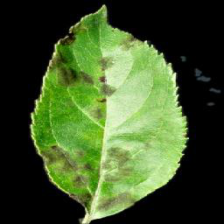

In [ ]:
query_url = "/content/Healthy-Unhealthy-Plants-Dataset-Segmented/" + leaves_dataframe.Plant.iloc[0] + '/' + leaves_dataframe.Image.iloc[0]

# load the image (a PIL.Image object is returned)
query_image_pil = tf.keras.utils.load_img(query_url, target_size=image_size, interpolation='bilinear')
query_image_pil

In [ ]:
query_image_np = tf.keras.preprocessing.image.img_to_array(query_image_pil)
query_image_np = np.expand_dims(query_image_np, axis=0)  # add batch dimension
query_feature = model(query_image_np)
query_feature

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[0.00000000e+00, 0.00000000e+00, 3.28308294e-34, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.41334858e-30,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.55179400e-30,
        1.17286566e-30, 1.54024019e-36, 3.46979329e-36, 0.00000000e+00,
        1.10837201e-32, 1.98499168e-38, 2.83642652e-37, 0.00000000e+00,
        1.76068029e-37, 2.45185346e-34, 0.00000000e+00, 1.49914084e-36,
        5.67898659e-32, 0.00000000e+00, 8.92972549e-34, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.89073006e-37,
        3.52071435e-35, 5.11824440e-31, 3.18032182e-29, 0.00000000e+00,
        1.49164666e-34, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00462308e-28, 2.87488578e-33,
        0.00000000e+00, 0.00000000e+00, 1.61161072e-36, 1.65489837e-34,
        2.467

In [ ]:
# search using cosine similarity == dot product between L2-normalized vectors
# descending order of scores

k = 10

#with cosine similarity 

scores = cosine_similarity(features, query_feature).squeeze()
score_cos = scores.argsort()[::-1]

topk = score_cos[:k]

topk

array([  0, 511,  25, 925, 989, 771, 678, 144, 338, 377])

In [ ]:
topk_image_paths = "/content/Healthy-Unhealthy-Plants-Dataset-Segmented/" + leaves_dataframe.Plant.iloc[topk] + '/' + leaves_dataframe.Image.iloc[topk]  # we leverage pandas to prepend 'Images/' to all the image filenames
topk_scores = scores[topk]
topk_plant = leaves_dataframe.Plant.iloc[topk]

show_results(topk_image_paths, topk_scores, topk_plant)

[1.         0.9999985  0.99999493 0.99998164 0.9999582  0.99993676
 0.99992096 0.99991715 0.99984354 0.9997973 ]
